# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implement ε-Greedy and UCB

In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
        pass
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """
        pass

In [3]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        assert(narms > 0)
        assert(epsilon >= 0 and epsilon <= 1)
        self.counts = np.zeros(narms)  # 1D array: the number of times each arm was played
        self.epsilon = epsilon         
        self.Qs = np.full(narms, Q0)   # 1D array: average rewards observed for each arm
        
        
    def play(self, tround, context=None):
        """
        explore with probability of epsilon, exploit with probability of 1-epsilon
        uniformly-random tie-breaking among euqally value-maximising arms
        """
        if np.random.rand() < self.epsilon:
            return np.random.choice(len(self.counts)) + 1
        else:
            idx_max_arms = np.where(self.Qs == np.max(self.Qs))[0]
            return np.random.choice(idx_max_arms) + 1
            
        
    def update(self, arm, reward, context=None):
        count = self.counts[arm-1]
        value = self.Qs[arm-1]
        
        self.counts[arm-1] = count + 1
        
        # for arms that is played the 1st time
        if count == 0:
            self.Qs[arm-1] = reward
        # for arms that have already been played before
        else:
            self.Qs[arm-1] = (value * count + reward) / self.counts[arm-1]
    

In [4]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        assert(narms > 0)
        assert(rho > 0)
        self.counts = np.zeros(narms) # 1D array: the number of times each arm was played
        self.rho = rho
        self.Qs = np.full(narms, Q0)  # 1D array: rewards for each arm taking interval terms into account
        self.mus = np.zeros(narms)    # 1D array: rewards for each arm without considering intervals
        
        
    def play(self, tround, context=None):
        """
        calculate rewards with considering of intervals, and then choose the arm that having the maximum
        reward. uniformly-random tie-breaking among euqally value-maximising arms.
        """
        for i in range(len(self.counts)):
            # update rewards only for arms that have already been played before
            if self.counts[i] > 0:
                interval_term = np.sqrt(self.rho * np.log(tround) / self.counts[i])
                self.Qs[i] = self.mus[i] + interval_term
        idx_max_arms = np.where(self.Qs == np.max(self.Qs))[0]
        return np.random.choice(idx_max_arms) + 1
        
        
    def update(self, arm, reward, context=None):
        count = self.counts[arm-1]
        mu = self.mus[arm-1]
        
        self.counts[arm-1] = count + 1
        self.mus[arm-1] = (mu * count + reward) / self.counts[arm-1]
    

## 2. Off-Policy Evaluation

In [5]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    d_features = contexts.shape[1]  # dimensionality of feature/context for each arm
    history = np.array([], dtype=float).reshape(0,d_features+2)  # the history as required on the paper
    payoff = np.array([], dtype=float)  # the payoff as described on the paper
    tround = 1
    for i, event_arm in enumerate(arms):
        reward = rewards[i]
        context = contexts[i].copy()
        
        # take the recommended arm by the mab algorithm
        mab_arm = mab.play(tround, context)
        
        if mab_arm != event_arm:
            continue
        else:
            mab.update(mab_arm, reward, context)
            tround += 1
            history = np.vstack([history, np.concatenate([context, [mab_arm, reward]])])
            payoff = np.append(payoff, reward)
            if nrounds != None and tround > nrounds:
                break
                
    return payoff
            

In [6]:
"""self-added cell for data pre-processing"""

def read_data(file_name='dataset.txt'):
    arms = []
    rewards = []
    contexts = []
    with open(file_name, 'r') as file:
        for line in file.readlines():
            tokens = line.strip().split()
            arms.append(tokens[0])
            rewards.append(tokens[1])
            contexts.append(tokens[2:])
    return (arms, rewards, contexts)

arms,rewards,contexts = read_data()

arms = np.array(arms).astype(int)
rewards = np.array(rewards).astype(float)
contexts = np.array(contexts).astype(float)

In [19]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.14125


In [24]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.15375


## 3. Contextual Bandits

In [25]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        assert(narms > 0)
        assert(ndims > 0)
        assert(alpha > 0)
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        
        # array of matrix in dimension (narms,ndims,ndims)
        self.As = np.array([np.eye(ndims) for i in range(narms)]).reshape(narms, ndims, ndims)
        # array of vectors in dimension (narms,ndims)
        self.bs = np.array([np.zeros(ndims).T for i in range(narms)])
        # 1D float array storing rewards
        self.ps = np.zeros(narms)
    
        
    def play(self, tround, context):
        """
        calculate rewards for each arm according to the algorithm shown on the paper
        tie-breaking is in a uniformly-random way
        """
        # extracting corresponding context for each arm
        xs = np.array([context[i*self.ndims:(i+1)*self.ndims] for i in range(self.narms)])
        
        for a in range(self.narms):
            x_a = xs[a]
            A_a = self.As[a]
            b_a = self.bs[a]
            # calculate theta_a
            theta_a = np.dot(inv(A_a), b_a)
            # calculate reward_a
            fst_term = np.dot(theta_a.T, x_a)
            snd_term = self.alpha * np.sqrt(np.dot(np.dot(x_a.T, inv(A_a)), x_a))
            self.ps[a] = fst_term + snd_term
            
        idx_max_arms = np.where(self.ps == np.max(self.ps))[0]
        return np.random.choice(idx_max_arms) + 1
        
    
    def update(self, arm, reward, context):
        x_a = context[(arm-1)*self.ndims:arm*self.ndims]
        A_a = self.As[arm-1]
        b_a = self.bs[arm-1]
        self.As[arm-1] = A_a + np.dot(x_a, x_a.T)
        self.bs[arm-1] = b_a + reward * x_a
    

In [26]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.2675


## 4. Evaluation
### 4.A.

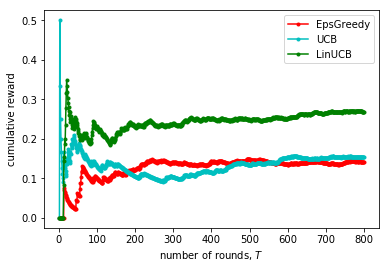

In [27]:
"""plotting the cumulative rewards for three mab algorithems implemented above"""

def calc_cumulative_reward(results):
    """
    calculate the cumulative rewards based on the array of rewards given for each round
    """
    c_results = np.zeros(len(results))
    c_rewards = 0
    for i,r in enumerate(results):
        c_rewards += r
        c_results[i] = c_rewards / (i + 1)
    return c_results

c_results_EpsGreedy = calc_cumulative_reward(results_EpsGreedy)
c_results_UCB = calc_cumulative_reward(results_UCB)
c_results_LinUCB = calc_cumulative_reward(results_LinUCB)

range_T = np.arange(1, len(c_results_LinUCB)+1, dtype=int)

plt.plot(range_T, c_results_EpsGreedy, 'r.-', label='EpsGreedy')
plt.plot(range_T, c_results_UCB, 'c.-', label='UCB')
plt.plot(range_T, c_results_LinUCB, 'g.-', label='LinUCB')
plt.xlabel('number of rounds, $T$')
plt.ylabel('cumulative reward')
plt.legend()
plt.show()

### 4.B.

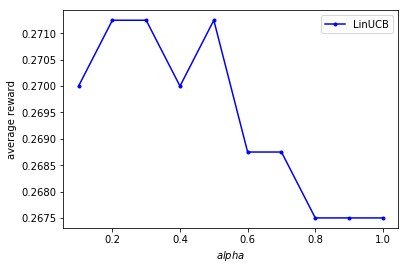

possible best alpha:  [0.2, 0.3, 0.5]


In [28]:
"""grid research on the hyperparameter alpha for LinBCA"""

alphas = [i/10.0 for i in range(1,11)]
results = np.zeros(len(alphas), dtype=float)

for i,alpha in enumerate(alphas):
    mab = LinUCB(10, 10, alpha)
    results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
    results[i] = np.mean(results_LinUCB)

plt.plot(alphas, results, 'b.-', label='LinUCB')
plt.xlabel('$alpha$')
plt.ylabel('average reward')
plt.legend()
plt.show()

print("possible best alpha: ", [alphas[i] for i in np.where(results==np.max(results))[0]])

## 5. KernelUCB

In [29]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [30]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
    def __init__(self, narms, ndims, gamma, eta, kern):
        assert(narms > 0)
        assert(ndims > 0)
        assert (gamma > 0)
        assert (eta > 0)
        self.narms = narms
        self.ndims = ndims
        self.gamma = gamma
        self.eta = eta
        self.kern = kern
        
        self.us = np.zeros(narms)
        self.us[0] = 1
        self.ys = np.empty(0)
        self.K_inv = np.empty(0)
        self.bs = np.empty(0)
        self.xs = []
        
    
    def play(self, tround, context):
        idx_max_arms = np.where(self.us == np.max(self.us))[0]
        return np.random.choice(idx_max_arms) + 1
        
    
    def update(self, arm, reward, context):
        x_t = context[(arm-1)*self.ndims:arm*self.ndims]
        inner_prod = self.kern(x_t, x_t)
        self.ys = np.append(self.ys, reward)
        self.xs.append(x_t)
        
        if len(self.ys) == 1:
            self.K_inv = 1/(inner_prod + self.gamma)
        else:
            self.bs = np.append(self.bs, inner_prod)
            K_22 = 1/(inner_prod + self.gamma - np.dot(np.dot(self.bs.T, self.K_inv), self.bs))
            K_11 = self.K_inv + K_22 * np.dot(np.dot(np.dot(self.K_inv, self.bs),self.bs.T),self.K_inv)
            K_12 = -K_22 * np.dot(inv(self.K_inv), self.bs)
            K_21 = -K_22 * np.dot(self.bs.T, self.K_inv)
            self.K_inv = np.vstack([np.hstack([K_11, K_12]), np.append(K_21, K_22)])
        
        for a in range(self.narms):
            k_xt = np.array([self.kern(x_t, x_i) for x_i in self.xs])
            x_at = context[a*self.ndims:(a+1)*self.ndims]
            s = np.sqrt(self.kern(x_at, x_at) - np.dot(np.dot(k_xt.T,self.K_inv),k_xt))
            self.us[a] = np.dot(np.dot(k_xt, self.K_inv), self.ys) + self.eta/np.sqrt(self.gamma)*s
        
    